In [1]:
# Let's start by initializing the database
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np
import matplotlib.pyplot as plt
import pcl

nusc = NuScenes(version='v0.1', dataroot='/data/nuscenes', verbose=True)


Loading NuScenes tables for version v0.1 ...
23 category,
8 attribute,
5 visibility,
6975 instance,
12 sensor,
1200 calibrated_sensor,
304715 ego_pose,
12 log,
100 scene,
3977 sample,
304715 sample_data,
99952 sample_annotation,
12 map,
Done loading in 4.9 seconds.
Reverse indexing ...
Done reverse indexing in 1.3 seconds.


In [40]:
# Get test token
my_scene_token = nusc.field2token('scene', 'name', 'scene-0008')[0]
scene_rec = nusc.get('scene',my_scene_token)
sample_rec = nusc.get('sample',scene_rec['first_sample_token'])

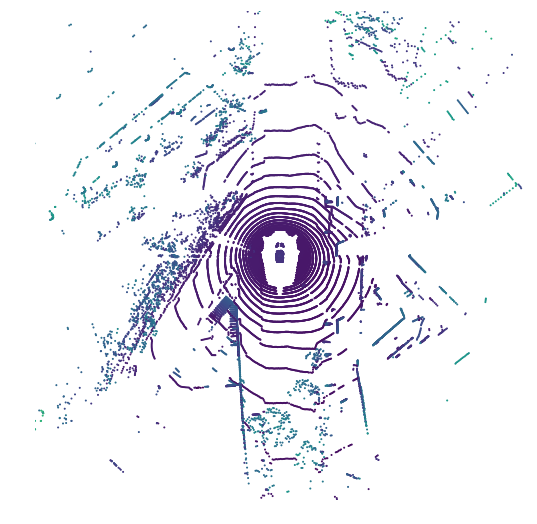

In [41]:
# Get points data
points = nusc.get_pointcloud_position(sample_rec['data']['LIDAR_TOP'])

In [42]:
import pcl
import numpy as np
import scipy.io as scio
points_fig = points
print(points.dtype)
scio.savemat('pointcloud_fig.mat', {'A':points})
points = points.astype(np.float32)
print(points.dtype)
scio.savemat('pointcloud.mat', {'A':points})
cloud = pcl.PointCloud(points.T)

float64
float32


In [43]:
# save as mat
# import scipy.io as scio
# scio.savemat('pointcloud.mat', {'A':points})

In [46]:
# -*- coding: utf-8 -*-
# Euclidean Cluster Extraction
# http://pointclouds.org/documentation/tutorials/cluster_extraction.php#cluster-extraction
import numpy as np
import pcl
import scipy.io as scio

# int main (int argc, char** argv)
# {
#   // Read in the cloud data
#   pcl::PCDReader reader;
#   pcl::PointCloud<pcl::PointXYZ>::Ptr cloud (new pcl::PointCloud<pcl::PointXYZ>), cloud_f (new pcl::PointCloud<pcl::PointXYZ>);
#   reader.read ("table_scene_lms400.pcd", *cloud);
#   std::cout << "PointCloud before filtering has: " << cloud->points.size () << " data points." << std::endl; //*

#   // Create the filtering object: downsample the dataset using a leaf size of 1cm
#   pcl::VoxelGrid<pcl::PointXYZ> vg;
#   pcl::PointCloud<pcl::PointXYZ>::Ptr cloud_filtered (new pcl::PointCloud<pcl::PointXYZ>);
#   vg.setInputCloud (cloud);
#   vg.setLeafSize (0.01f, 0.01f, 0.01f);
#   vg.filter (*cloud_filtered);
#   std::cout << "PointCloud after filtering has: " << cloud_filtered->points.size ()  << " data points." << std::endl; //*
vg = cloud.make_voxel_grid_filter()
vg.set_leaf_size (0.01, 0.01, 0.01)
cloud_filtered = vg.filter ()

#   // Create the segmentation object for the planar model and set all the parameters
#   pcl::SACSegmentation<pcl::PointXYZ> seg;
#   pcl::PointIndices::Ptr inliers (new pcl::PointIndices);
#   pcl::ModelCoefficients::Ptr coefficients (new pcl::ModelCoefficients);
#   pcl::PointCloud<pcl::PointXYZ>::Ptr cloud_plane (new pcl::PointCloud<pcl::PointXYZ> ());
#   pcl::PCDWriter writer;
#   seg.setOptimizeCoefficients (true);
#   seg.setModelType (pcl::SACMODEL_PLANE);
#   seg.setMethodType (pcl::SAC_RANSAC);
#   seg.setMaxIterations (100);
#   seg.setDistanceThreshold (0.02);
seg = cloud.make_segmenter()
seg.set_optimize_coefficients (True)
seg.set_model_type (pcl.SACMODEL_PLANE)
seg.set_method_type (pcl.SAC_RANSAC)
seg.set_MaxIterations (100)
seg.set_distance_threshold (0.02)

#   int i=0, nr_points = (int) cloud_filtered->points.size ();
#   while (cloud_filtered->points.size () > 0.3 * nr_points)
#   {
#     // Segment the largest planar component from the remaining cloud
#     seg.setInputCloud (cloud_filtered);
#     seg.segment (*inliers, *coefficients);
#     if (inliers->indices.size () == 0)
#     {
#       std::cout << "Could not estimate a planar model for the given dataset." << std::endl;
#       break;
#     }
#     // Extract the planar inliers from the input cloud
#     pcl::ExtractIndices<pcl::PointXYZ> extract;
#     extract.setInputCloud (cloud_filtered);
#     extract.setIndices (inliers);
#     extract.setNegative (false);
# 
#     // Get the points associated with the planar surface
#     extract.filter (*cloud_plane);
#     std::cout << "PointCloud representing the planar component: " << cloud_plane->points.size () << " data points." << std::endl;
# 
#     // Remove the planar inliers, extract the rest
#     extract.setNegative (true);
#     extract.filter (*cloud_f);
#     *cloud_filtered = *cloud_f;
#   }

i = 0
nr_points = cloud_filtered.size
# while nr_points > 0.3 * nr_points:
#     # Segment the largest planar component from the remaining cloud
#     [inliers, coefficients] = seg.segment()
#     # extract = cloud_filtered.extract()
#     # extract = pcl.PointIndices()
#     cloud_filtered.extract(extract)
#     extract.set_Indices (inliers)
#     extract.set_Negative (false)
#     cloud_plane = extract.filter ()
#     
#     extract.set_Negative (True)
#     cloud_f = extract.filter ()
#     cloud_filtered = cloud_f


# Creating the KdTree object for the search method of the extraction
# pcl::search::KdTree<pcl::PointXYZ>::Ptr tree (new pcl::search::KdTree<pcl::PointXYZ>);
# tree->setInputCloud (cloud_filtered);
tree = cloud_filtered.make_kdtree()
# tree = cloud_filtered.make_kdtree_flann()


# std::vector<pcl::PointIndices> cluster_indices;
# pcl::EuclideanClusterExtraction<pcl::PointXYZ> ec;
# ec.setClusterTolerance (0.02); // 2cm
# ec.setMinClusterSize (100);
# ec.setMaxClusterSize (25000);
# ec.setSearchMethod (tree);
# ec.setInputCloud (cloud_filtered);
# ec.extract (cluster_indices);
ec = cloud_filtered.make_EuclideanClusterExtraction()
ec.set_ClusterTolerance (0.02)
ec.set_MinClusterSize (100)
ec.set_MaxClusterSize (25000)
ec.set_SearchMethod (tree)
cluster_indices = ec.Extract()

print('cluster_indices : ' + str(cluster_indices.count) + " count.")
# print('cluster_indices : ' + str(cluster_indices.indices.max_size) + " count.")

#   int j = 0;
#   for (std::vector<pcl::PointIndices>::const_iterator it = cluster_indices.begin (); it != cluster_indices.end (); ++it)
#   {
#     pcl::PointCloud<pcl::PointXYZ>::Ptr cloud_cluster (new pcl::PointCloud<pcl::PointXYZ>);
#     for (std::vector<int>::const_iterator pit = it->indices.begin (); pit != it->indices.end (); ++pit)
#       cloud_cluster->points.push_back (cloud_filtered->points[*pit]); //*
#     cloud_cluster->width = cloud_cluster->points.size ();
#     cloud_cluster->height = 1;
#     cloud_cluster->is_dense = true;
# 
#     std::cout << "PointCloud representing the Cluster: " << cloud_cluster->points.size () << " data points." << std::endl;
#     std::stringstream ss;
#     ss << "cloud_cluster_" << j << ".pcd";
#     writer.write<pcl::PointXYZ> (ss.str (), *cloud_cluster, false); //*
#     j++;
#   }
# 

cloud_cluster = pcl.PointCloud()
obj_line = np.empty([len(cluster_indices),3],dtype = float)
for j, indices in enumerate(cluster_indices):
    # cloudsize = indices
    print('indices = ' + str(len(indices)))
    # cloudsize = len(indices)
    points = np.zeros((len(indices), 3), dtype=np.float32)
    # points = np.zeros((cloudsize, 3), dtype=np.float32)
    
    # for indice in range(len(indices)):
    for i, indice in enumerate(indices):
        # print('dataNum = ' + str(i) + ', data point[x y z]: ' + str(cloud_filtered[indice][0]) + ' ' + str(cloud_filtered[indice][1]) + ' ' + str(cloud_filtered[indice][2]))
        # print('PointCloud representing the Cluster: ' + str(cloud_cluster.size) + " data points.")
        points[i][0] = cloud_filtered[indice][0]
        points[i][1] = cloud_filtered[indice][1]
        points[i][2] = cloud_filtered[indice][2]

    x_mean = (points[:,0].max()+points[:,0].min())/2
    y_mean = (points[:,1].max()+points[:,1].min())/2
    loc_dot= np.hstack((x_mean,y_mean))
    
    x_det = points[:,0].max()-points[:,0].min()
    y_det = points[:,0].max()-points[:,0].min()
    radius = (x_det+y_det)/2

    obj_line[j,:] = np.hstack((loc_dot,radius))
          
    cloud_cluster.from_array(points)
    print(cloud_cluster[0])
#     ss = "cloud_cluster_" + str(j) + ".pcd";
#     pcl.save(cloud_cluster, ss)
#     ss_matlab = "cloud_cluster_" + str(j) + ".mat";
#     scio.savemat(ss_matlab, {'A':cloud_cluster})


cluster_indices : <built-in method count of list object at 0x7f3965b76508> count.
indices = 4073
(0.0008121654973365366, -0.35507169365882874, -0.002183237113058567)
indices = 1772
(-0.5511812567710876, -0.10998763889074326, -0.35424700379371643)
indices = 334
(0.526896059513092, -0.41826319694519043, -0.3512986898422241)
indices = 225
(-0.09864930063486099, -0.7324432134628296, -0.33171358704566956)
indices = 223
(-0.15081942081451416, -0.5917723774909973, -0.30415499210357666)
indices = 175
(0.46964865922927856, -0.7670568227767944, -0.3777824938297272)


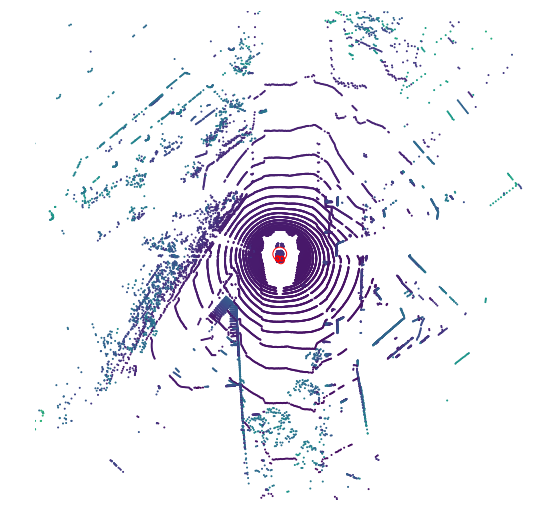

In [45]:
# plot prediction by obj_mean
nusc.plot_pointcloud_prediction(points_fig, obj_line)

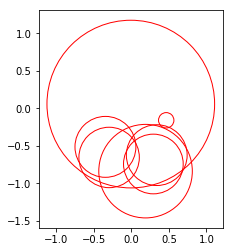

8

In [23]:
from matplotlib.patches import Ellipse, Circle
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(obj_line.shape[0]):
    cir1 = Circle(xy = (obj_line[i][0], obj_line[i][1]), radius=obj_line[i][2], color ='r', fill=False) 
    ax.add_patch(cir1)
plt.axis('scaled')

plt.show()

obj_line.shape[0]

